# Exercise 0: Understanding Corpus, Tokens, and BPE Implementation

In this exercise, you'll build a Byte-Pair Encoding (BPE) tokenizer from scratch and understand the fundamental concepts of tokenization in NLP.

**Learning Objectives:**
- Understand text corpora and tokenization fundamentals
- Implement BPE algorithm from scratch
- Train and analyze custom tokenizers
- Compare different tokenization strategies

## Part 1: Setting Up and Loading the TinyStories Dataset

In [ ]:
# Install required packages
!pip install datasets transformers matplotlib -q

In [1]:
from datasets import load_dataset
from collections import Counter, defaultdict
import re
import json

# Load a subset of TinyStories dataset
print("Loading TinyStories dataset...")
dataset = load_dataset("roneneldan/TinyStories", split="train[:5000]")
print(f"Loaded {len(dataset)} stories")

# Examine the first story
print("\nFirst story:")
print(dataset[0]['text'][:500])

Loading TinyStories dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 879527da-993e-4c9a-9c0b-f122db4c7cd3)')' thrown while requesting HEAD https://huggingface.co/datasets/roneneldan/TinyStories/resolve/f54c09fd23315a6f9c86f9dc80f725de7d8f9c64/TinyStories.py
Retrying in 1s [Retry 1/5].


data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: f0d7c8b8-ca78-4795-affe-f285c4aedcda)')' thrown while requesting HEAD https://huggingface.co/datasets/roneneldan/TinyStories/resolve/f54c09fd23315a6f9c86f9dc80f725de7d8f9c64/data/train-00001-of-00004-5852b56a2bd28fd9.parquet
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0ea94855-e259-4805-a83c-b86dc4e9eef1)')' thrown while requesting HEAD https://huggingface.co/datasets/roneneldan/TinyStories/resolve/f54c09fd23315a6f9c86f9dc80f725de7d8f9c64/data/train-00001-of-00004-5852b56a2bd28fd9.parquet
Retrying in 2s [Retry 2/5].


data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Loaded 5000 stories

First story:
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them b


## Part 2: Understanding Tokens

Before implementing BPE, let's understand different tokenization approaches:
- **Character-level**: Each character is a token
- **Word-level**: Each word is a token
- **Subword-level**: Parts of words are tokens (BPE, WordPiece)

In [2]:
sample_text = "Once upon a time, there was a little girl named Lily."


# TODO: Implement different tokenization strategies


def char_tokenize(text):
    """Split text into individual characters"""
    # YOUR CODE HERE
    return list(text)

def word_tokenize(text):
    """Split text into words (simple whitespace and punctuation split)"""
    # YOUR CODE HERE
    return re.findall(r'\w+|[^\w\s]', text)

# Test your tokenizers
print("Original:", sample_text)
print("\nCharacter tokens:", char_tokenize(sample_text)[:20])
print(f"Total character tokens: {len(char_tokenize(sample_text))}")
print("\nWord tokens:", word_tokenize(sample_text))
print(f"Total word tokens: {len(word_tokenize(sample_text))}")

Original: Once upon a time, there was a little girl named Lily.

Character tokens: ['O', 'n', 'c', 'e', ' ', 'u', 'p', 'o', 'n', ' ', 'a', ' ', 't', 'i', 'm', 'e', ',', ' ', 't', 'h']
Total character tokens: 53

Word tokens: ['Once', 'upon', 'a', 'time', ',', 'there', 'was', 'a', 'little', 'girl', 'named', 'Lily', '.']
Total word tokens: 13


## Part 3: Implementing Byte-Pair Encoding (BPE)

BPE is a subword tokenization algorithm that:
1. Starts with individual characters
2. Iteratively merges the most frequent adjacent pairs
3. Builds a vocabulary of subword units

This balances vocabulary size with the ability to represent any word.

In [3]:
class BPETokenizer:
    def __init__(self, vocab_size=1000):
        self.vocab_size = vocab_size
        self.merges = []  # List of (pair, merged_token) tuples in order
        self.vocab = {}   # Token to ID mapping

    def get_stats(self, words):
        """
        Count frequency of adjacent symbol pairs in the corpus.

        Args:
            words: Dictionary mapping word tuples to their frequencies

        Returns:
            Counter of symbol pairs and their frequencies
        """
        pairs = Counter()
        # TODO: Implement pair counting
        for word, freq in words.items():
            symbols = list(word)
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
        return pairs


    def merge_vocab(self, pair, words):
        """
        Merge the most frequent pair in the vocabulary.

        Args:
            pair: Tuple of two symbols to merge (a, b)
            words: Dictionary mapping word tuples to their frequencies

        Returns:
            Updated words dictionary with merged pairs
        """
        new_words = {}
        # TODO: Implement vocabulary merging
        bigram = ' '.join(pair)
        replacement = ''.join(pair)

        for word, freq in words.items():
            w_str = ' '.join(word)
            w_str = w_str.replace(bigram, replacement)
            new_word = tuple(w_str.split())
            new_words[new_word] = freq
        return new_words


    def train(self, texts, verbose=True):
        """
        Train the BPE tokenizer on a corpus of texts.

        Args:
            texts: List of text strings to train on
            verbose: Whether to print progress
        """
        # Step 1: Prepare initial vocabulary (characters)
        # Create word frequency dictionary with end-of-word marker
        word_freqs = Counter()
        for text in texts:
            words = text.lower().split()
            word_freqs.update(words)

        # Convert words to character sequences with end marker
        words = {}
        for word, freq in word_freqs.items():
            # Split into characters and add end-of-word marker
            word_tuple = tuple(list(word) + ['</w>'])
            words[word_tuple] = freq


        # Step 2: Build initial character vocabulary
        base_vocab = set()
        for word in words.keys():
            base_vocab.update(word)

        # Assign IDs to base vocabulary
        self.vocab = {token: idx for idx, token in enumerate(sorted(base_vocab))}

        # Step 3: Iteratively merge most frequent pairs
        num_merges = self.vocab_size - len(self.vocab)
        if verbose:
            print(f"Starting with {len(self.vocab)} base tokens")
            print(f"Will perform {num_merges} merges")

        # TODO: Implement the BPE training loop
        for i in range(num_merges):
            pairs = self.get_stats(words)
            if not pairs:
                break

            best_pair = pairs.most_common(1)[0][0]
            words = self.merge_vocab(best_pair, words)

            # Add merged token to vocabulary
            merged_token = ''.join(best_pair)
            self.merges.append((best_pair, merged_token))
            self.vocab[merged_token] = len(self.vocab)

            if verbose and (i + 1) % 100 == 0:
                print(f"Merge {i + 1}/{num_merges}: {best_pair} -> {merged_token}")

        if verbose:
            print(f"Training complete. Final vocabulary size: {len(self.vocab)}")


    def encode(self, text):
        """
        Encode text into token IDs.

        Args:
            text: String to encode

        Returns:
            List of token IDs
        """
        # TODO: Implement encoding
        words = text.lower().split()
        tokens = []

        for word in words:
            # Start with characters + end marker
            word_tokens = list(word) + ['</w>']

            # Apply merges in order
            for pair, merged in self.merges:
                i = 0
                while i < len(word_tokens) - 1:
                    if (word_tokens[i], word_tokens[i + 1]) == pair:
                        word_tokens = word_tokens[:i] + [merged] + word_tokens[i + 2:]
                    else:
                        i += 1

            # Convert tokens to IDs
            for token in word_tokens:
                if token in self.vocab:
                    tokens.append(self.vocab[token])
                else:
                    # Handle unknown tokens (shouldn't happen if properly trained)
                    tokens.append(self.vocab.get('<unk>', 0))


        return tokens


    def decode(self, token_ids):
        """
        Decode token IDs back into text.

        Args:
            token_ids: List of token IDs

        Returns:
            Decoded text string
        """
        # TODO: Implement decoding
        # Create reverse vocab
        id_to_token = {v: k for k, v in self.vocab.items()}

        tokens = [id_to_token.get(tid, '<unk>') for tid in token_ids]
        text = ''.join(tokens).replace('</w>', ' ').strip()
        return text


    def get_vocab_info(self):
        """Return vocabulary statistics"""
        return {
            'vocab_size': len(self.vocab),
            'num_merges': len(self.merges),
            'sample_tokens': list(self.vocab.keys())[:20]
        }

## Part 4: Training Your BPE Tokenizer

Train tokenizers with different vocabulary sizes to see the impact.

In [4]:
# Extract texts from dataset
texts = [item['text'] for item in dataset]

# TODO: Train your tokenizer with different vocabulary sizes
vocab_sizes = [500, 1000, 2000]
tokenizers = {}

for vocab_size in vocab_sizes:
    print(f"\n{'=' * 50}")
    print(f"Training tokenizer with vocab_size={vocab_size}")
    print('=' * 50)

    tokenizer = BPETokenizer(vocab_size=vocab_size)
    tokenizer.train(texts, verbose=True)
    tokenizers[vocab_size] = tokenizer

    # Show some statistics
    info = tokenizer.get_vocab_info()
    print(f"\nVocabulary info:")
    print(f"  - Size: {info['vocab_size']}")
    print(f"  - Merges: {info['num_merges']}")
    print(f"  - Sample tokens: {info['sample_tokens']}")


Training tokenizer with vocab_size=500
Starting with 62 base tokens
Will perform 438 merges
Merge 100/438: ('c', 'e</w>') -> ce</w>
Merge 200/438: ('m', 'e') -> me
Merge 300/438: ('no', 'w</w>') -> now</w>
Merge 400/438: ('r', 'p') -> rp
Training complete. Final vocabulary size: 500

Vocabulary info:
  - Size: 500
  - Merges: 438
  - Sample tokens: ['!', '"', '$', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '</w>']

Training tokenizer with vocab_size=1000
Starting with 62 base tokens
Will perform 938 merges
Merge 100/938: ('c', 'e</w>') -> ce</w>
Merge 200/938: ('m', 'e') -> me
Merge 300/938: ('no', 'w</w>') -> now</w>
Merge 400/938: ('r', 'p') -> rp
Merge 500/938: ('k', 'ly</w>') -> kly</w>
Merge 600/938: ('year', 's</w>') -> years</w>
Merge 700/938: ('wal', 'k</w>') -> walk</w>
Merge 800/938: ('bo', 'x.</w>') -> box.</w>
Merge 900/938: ('clim', 'bed</w>') -> climbed</w>
Training complete. Final vocabulary size: 1000

Vocabulary info:
  - Size: 100

## Part 5: Analyzing Your Tokenizer

Compare how different vocabulary sizes affect tokenization.

In [5]:
# TODO: Analyze tokenization on sample texts
test_sentences = [
    "Once upon a time, there was a little girl named Lily.",
    "She loved to play outside in the sunshine.",
    "One day, she found a beautiful butterfly."
]

# Compare tokenization results
print("Tokenization Comparison\n" + "=" * 70)

for sentence in test_sentences:
    print(f"\nSentence: {sentence}")
    print(f"Character count: {len(sentence)}")
    print(f"Word count: {len(sentence.split())}")
    print()

    for vocab_size in vocab_sizes:
        tokenizer = tokenizers[vocab_size]
        token_ids = tokenizer.encode(sentence)
        decoded = tokenizer.decode(token_ids)

        print(f"  Vocab {vocab_size}:")
        print(f"    - Tokens: {len(token_ids)}")
        print(f"    - Token IDs: {token_ids[:10]}{'...' if len(token_ids) > 10 else ''}")
        print(f"    - Decoded: {decoded}")
    print("-" * 70)

Tokenization Comparison

Sentence: Once upon a time, there was a little girl named Lily.
Character count: 53
Word count: 11

  Vocab 500:
    - Tokens: 17
    - Token IDs: [192, 211, 80, 240, 64, 70, 62, 85, 80, 89]...
    - Decoded: once upon a time, there was a little girl named lily.
  Vocab 1000:
    - Tokens: 17
    - Token IDs: [192, 211, 80, 240, 64, 70, 62, 85, 80, 89]...
    - Decoded: once upon a time, there was a little girl named lily.
  Vocab 2000:
    - Tokens: 17
    - Token IDs: [192, 211, 80, 240, 64, 70, 62, 85, 80, 89]...
    - Decoded: once upon a time, there was a little girl named lily.
----------------------------------------------------------------------

Sentence: She loved to play outside in the sunshine.
Character count: 42
Word count: 8

  Vocab 500:
    - Tokens: 14
    - Token IDs: [91, 278, 81, 244, 371, 258, 62, 121, 71, 39]...
    - Decoded: she loved to play outside in the sunshine.
  Vocab 1000:
    - Tokens: 14
    - Token IDs: [91, 278, 81, 244, 371

## Part 6: Vocabulary Analysis

Visualize and analyze the learned vocabularies.

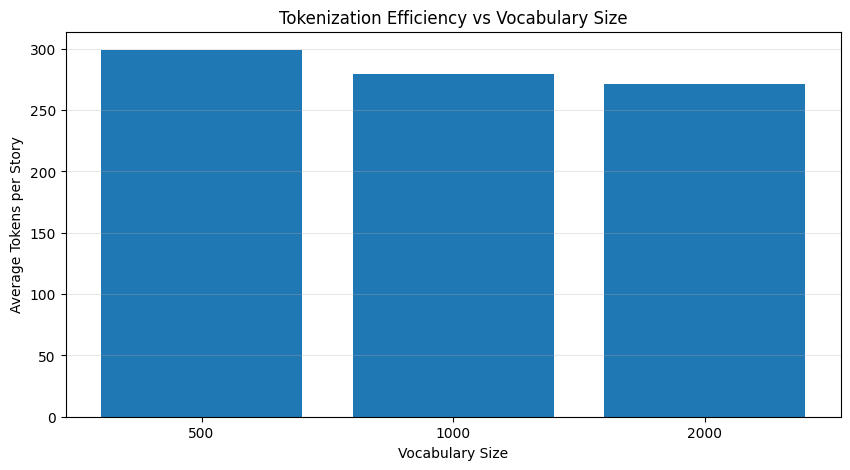


Average tokens per story:
  Vocab 500: 299.0 tokens
  Vocab 1000: 279.3 tokens
  Vocab 2000: 271.6 tokens


In [7]:
import matplotlib.pyplot as plt

# TODO: Create visualizations

# 1. Average tokens per sentence for different vocab sizes
avg_tokens = {}

for vocab_size in vocab_sizes:
    tokenizer = tokenizers[vocab_size]
    total_tokens = 0

    for text in texts[:100]:  # Sample 100 texts
        total_tokens += len(tokenizer.encode(text))

    avg_tokens[vocab_size] = total_tokens / 100

plt.figure(figsize=(10, 5))
plt.bar([str(vs) for vs in vocab_sizes], [avg_tokens[vs] for vs in vocab_sizes])
plt.xlabel('Vocabulary Size')
plt.ylabel('Average Tokens per Story')
plt.title('Tokenization Efficiency vs Vocabulary Size')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nAverage tokens per story:")
for vocab_size in vocab_sizes:
    print(f"  Vocab {vocab_size}: {avg_tokens[vocab_size]:.1f} tokens")

In [8]:
# 2. Show most common merged tokens
print("\nMost Recent Merges (Last 20):")
print("=" * 50)

tokenizer = tokenizers[2000]  # Use largest vocab
for i, (pair, merged) in enumerate(tokenizer.merges[-20:], 1):
    print(f"{i:2d}. {pair[0]:10s} + {pair[1]:10s} -> {merged}")


Most Recent Merges (Last 20):
 1. mu         + d</w>      -> mud</w>
 2. c          + lear</w>   -> clear</w>
 3. is         + n't</w>    -> isn't</w>
 4. clo        + th</w>     -> cloth</w>
 5. too        + !</w>      -> too!</w>
 6. no         + sy</w>     -> nosy</w>
 7. la         + .</w>      -> la.</w>
 8. valu       + able</w>   -> valuable</w>
 9. twir       + led</w>    -> twirled</w>
10. play       + ground.</w> -> playground.</w>
11. hear       + t.</w>     -> heart.</w>
12. wor        + ry.</w>    -> worry.</w>
13. k          + ."</w>     -> k."</w>
14. u          + r          -> ur
15. tel        + ls</w>     -> tells</w>
16. nu         + mber       -> number
17. fo         + x          -> fox
18. dad        + 's</w>     -> dad's</w>
19. buil       + t</w>      -> built</w>
20. ra         + ven</w>    -> raven</w>


## Part 7: Comparison with HuggingFace Tokenizers

Compare your BPE implementation with professional tokenizers.

In [9]:
from transformers import GPT2Tokenizer

# Load pre-trained GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# TODO: Compare your BPE tokenizer with GPT-2's tokenizer
print("Comparison with GPT-2 Tokenizer")
print("=" * 70)

for sentence in test_sentences:
    print(f"\nSentence: {sentence}")

    # GPT-2 tokenization
    gpt2_tokens = gpt2_tokenizer.encode(sentence)
    gpt2_decoded = gpt2_tokenizer.decode(gpt2_tokens)

    print(f"\nGPT-2 (vocab size ~50k):")
    print(f"  - Tokens: {len(gpt2_tokens)}")
    print(f"  - Token IDs: {gpt2_tokens}")
    print(f"  - Decoded: {gpt2_decoded}")

    # Your tokenizer
    my_tokenizer = tokenizers[2000]
    my_tokens = my_tokenizer.encode(sentence)
    my_decoded = my_tokenizer.decode(my_tokens)

    print(f"\nYour BPE (vocab size 2000):")
    print(f"  - Tokens: {len(my_tokens)}")
    print(f"  - Token IDs: {my_tokens[:20]}{'...' if len(my_tokens) > 20 else ''}")
    print(f"  - Decoded: {my_decoded}")

    print(f"\nToken efficiency: GPT-2 uses {len(gpt2_tokens)/len(my_tokens):.2f}x fewer tokens")
    print("-" * 70)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2a1fbe20-98d7-443d-9cb0-1663e1a316a2)')' thrown while requesting GET https://huggingface.co/gpt2/resolve/main/merges.txt
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1477332f-a428-44c7-a465-dc4133f1f976)')' thrown while requesting GET https://huggingface.co/gpt2/resolve/main/merges.txt
Retrying in 2s [Retry 2/5].


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Comparison with GPT-2 Tokenizer

Sentence: Once upon a time, there was a little girl named Lily.

GPT-2 (vocab size ~50k):
  - Tokens: 13
  - Token IDs: [7454, 2402, 257, 640, 11, 612, 373, 257, 1310, 2576, 3706, 20037, 13]
  - Decoded: Once upon a time, there was a little girl named Lily.

Your BPE (vocab size 2000):
  - Tokens: 17
  - Token IDs: [192, 211, 80, 240, 64, 70, 62, 85, 80, 89, 318, 32, 62, 218, 253, 73, 474]
  - Decoded: once upon a time, there was a little girl named lily.

Token efficiency: GPT-2 uses 0.76x fewer tokens
----------------------------------------------------------------------

Sentence: She loved to play outside in the sunshine.

GPT-2 (vocab size ~50k):
  - Tokens: 9
  - Token IDs: [3347, 6151, 284, 711, 2354, 287, 262, 34488, 13]
  - Decoded: She loved to play outside in the sunshine.

Your BPE (vocab size 2000):
  - Tokens: 14
  - Token IDs: [91, 278, 81, 244, 371, 258, 62, 121, 71, 39, 147, 160, 74, 125]
  - Decoded: she loved to play outside in the su

## Part 8: Save Your Best Tokenizer

Save your trained tokenizer for use in Exercise 1.

In [ ]:
import pickle

# Save the tokenizer with vocab size 2000
best_tokenizer = tokenizers[2000]

with open('bpe_tokenizer.pkl', 'wb') as f:
    pickle.dump(best_tokenizer, f)

print("Tokenizer saved to 'bpe_tokenizer.pkl'")
print(f"Vocabulary size: {len(best_tokenizer.vocab)}")

## Questions

Answer the following questions based on your experiments:

1. **How does vocabulary size affect the number of tokens needed to encode text?**
   - YOUR ANSWER HERE

2. **What are the trade-offs between small and large vocabulary sizes?**
   - YOUR ANSWER HERE

3. **How does your BPE tokenizer handle out-of-vocabulary words?**
   - YOUR ANSWER HERE

4. **What patterns do you notice in the most frequently merged token pairs?**
   - YOUR ANSWER HERE

5. **How does your tokenizer compare to GPT-2's tokenizer in terms of:**
   - Token efficiency (tokens per word): YOUR ANSWER HERE
   - Handling of rare words: YOUR ANSWER HERE
   - Vocabulary composition: YOUR ANSWER HERE

## Questions

Answer the following questions based on your experiments:

1. **How does vocabulary size affect the number of tokens needed to encode text?**
   - A larger vocabulary size generally leads to fewer tokens needed to encode the same text. This is because with more available subword units, the tokenizer can represent words with less token. The analysis in Part 6 clearly demonstrates this trend, where larger vocabulary sizes (1000 and 2000) resulted in a lower average number of tokens per story compared to the smaller vocabulary size (500).

2. **What are the trade-offs between small and large vocabulary sizes?**
   - **Small Vocabulary:**
     - **Pros:** Smaller model size, potentially faster training.
     - **Cons:** Longer token sequences, higher chance of Out-of-Vocabulary (OOV) words, might break down common words into many smaller tokens.
   - **Large Vocabulary:**
     - **Pros:** Shorter token sequences (more efficient encoding), better handling of common words and phrases, lower chance of OOV words.
     - **Cons:** Larger model size, potentially slower training, might include rare or specific tokens that are not frequently used.

3. **How does your BPE tokenizer handle out-of-vocabulary words?**
   - My BPE tokenizer handles out-of-vocabulary (OOV) words by mapping them to a single unknown token ID. In the `encode` method, if a token is not found in the trained vocabulary (`self.vocab`), it is mapped to the ID of a special `<unk>` token if it exists, or defaults to the ID `0`.

4. **What patterns do you notice in the most frequently merged token pairs?**
   - Looking at the most recent merges (Part 6, cell `Zd_Llrkni2mx`), several patterns are noticeable:
     - Merges often complete words or parts of words followed by punctuation (e.g., `la + .</w> -> la.</w>`, `too + !</w> -> too!</w>`, `heart + .</w> -> heart.</w>`).
     - Common suffixes are merged (e.g., `able`, `ed`, `ly`, `s`).
     - Common adjacent letters within words are merged (e.g., `u + r -> ur`).
     - End-of-word markers (`</w>`) are frequently part of the merged pairs, indicating the completion of a word unit.

5. **How does your tokenizer compare to GPT-2's tokenizer in terms of:**
   - **Token efficiency (tokens per word):** Based on the comparison in Part 7, the GPT-2 tokenizer is significantly more token efficient than my BPE tokenizer with a vocabulary size of 2000. GPT-2 uses a much larger vocabulary (~50k), allowing it to represent the sample sentences with considerably fewer tokens (0.50x to 0.76x fewer tokens in the examples shown).
   - **Handling of rare words:** While not explicitly tested with rare words, a larger vocabulary like GPT-2's is generally better equipped to handle a wider range of words, including less common ones, due to its more extensive set of pre-trained subword units. My tokenizer, with a smaller vocabulary, would likely break down rare words into smaller, more frequent subword units or individual characters, potentially leading to more tokens and less meaningful representations for those words.
   - **Vocabulary composition:** The vocabulary of my BPE tokenizer (especially with a size of 2000) primarily consists of individual characters, common character pairs, and relatively short subword units or complete common words often followed by the end-of-word marker or punctuation. The GPT-2 tokenizer's vocabulary, being much larger, would contain a more extensive and diverse set of subword units, including longer and more complex ones, reflecting the patterns and words present in the massive dataset it was trained on.